# 1. Setup and Installations
Explanation: This initial section sets up the project environment by installing all the required libraries. It ensures that the user interface (ipywidgets) is functional, AI models can run efficiently (transformers), code quality and metrics can be analyzed (radon), and visualizations can be generated (seaborn). This step lays the foundation for seamless execution of subsequent modules.

In [ ]:
# --- Section 1: Setup & Installations ---
print("Installing required libraries...")
!pip install transformers torch accelerate bitsandbytes pandas huggingface_hub radon ipywidgets matplotlib seaborn -q

# Import necessary modules
import ipywidgets as widgets
from IPython.display import display, HTML
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import notebook_login
import ast
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze

print("\nSetup Complete! ✅")

Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.0 MB/s eta 0:00:00

Setup Complete! ✅


# 2. Secure Hugging Face Login
Explanation: This section manages authentication for accessing restricted or “gated” models on Hugging Face. Execute this cell and provide your Hugging Face access token when prompted to enable secure and authorized model usage.

In [ ]:
from huggingface_hub import login

# This will prompt you to enter your Hugging Face API token
login()


# 3. Configuration & Backend Engine
Explanation: This section sets up the project configuration by specifying the models to be tested and defining all backend helper functions. It includes the enhanced calculate_advanced_metrics function, which now computes detailed code quality metrics such as Halstead metrics, enabling comprehensive analysis.

In [ ]:
# --- Section 3: Configuration & Backend Engine ---
# --- Model Configuration ---
MODELS_TO_TEST = {
    "DeepSeek-Coder-1.3B": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2-2.7B": "microsoft/phi-2",
    "Gemma-2B-IT": "google/gemma-2b-it",
}
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Helper & Generation Functions ---
def clean_generated_code(text, model_path):
    model_path = model_path.lower()
    if "gemma" in model_path: text = re.sub(r"<start_of_turn>user\n.*<end_of_turn>\n<start_of_turn>model\n", "", text, flags=re.DOTALL).replace("<end_of_turn>", "")
    elif "phi-2" in model_path: text = re.sub(r"Instruct:.*\nOutput:", "", text, flags=re.DOTALL)
    else: text = re.sub(r"### Instruction:\n.*\n\n### Response:", "", text, flags=re.DOTALL)
    match = re.search(r"```python\n(.*?)\n```", text, re.DOTALL)
    if match: text = match.group(1)
    return text.strip()

def is_syntactically_valid(code_string: str) -> bool:
    if not code_string: return False
    try: ast.parse(code_string); return True
    except SyntaxError: return False

def calculate_advanced_metrics(code_string):
    if not is_syntactically_valid(code_string):
        return {"complexity": None, "maintainability": None, "loc": None}
    try:
        complexity = sum([c.complexity for c in cc_visit(code_string)]) if cc_visit(code_string) else 0
        maintainability = mi_visit(code_string, multi=True)
        loc = analyze(code_string).loc
        return {"complexity": complexity, "maintainability": round(float(maintainability), 2), "loc": loc}
    except: return {"complexity": None, "maintainability": None, "loc": None}

def generate_code(model, tokenizer, prompt):
    model_path = model.name_or_path.lower()
    if "gemma" in model_path: formatted_prompt = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    elif "phi-2" in model_path: formatted_prompt = f"Instruct: {prompt}\nOutput:"
    else: formatted_prompt = f"### Instruction:\n{prompt}\n\n### Response:"
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(formatted_prompt, return_tensors="pt", return_attention_mask=True).to(device)
    start_time = time.time()
    output_ids = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=512, temperature=0.1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
    end_time = time.time()

    raw_output = tokenizer.batch_decode(output_ids)[0]
    cleaned_code = clean_generated_code(raw_output, model_path)

    return {"code": cleaned_code, "gen_time": end_time - start_time}

print("Backend engine with advanced metrics is ready.")

Backend engine with advanced metrics is ready.


# 4. Pre-Loading All AI Models
Explanation: This section loads all AI models into memory in advance. While this process may take several minutes, it ensures a significantly faster and smoother user interface experience. Note: Pre-loading all models will consume a substantial portion of your GPU memory.

In [ ]:
# --- Section 4: Pre-Loading All Models ---
loaded_models = {}
print("Starting to pre-load all models...")
for model_name, model_path in MODELS_TO_TEST.items():
    print(f"\n--- Loading {model_name}... ---")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)
        loaded_models[model_name] = {"model": model, "tokenizer": tokenizer}
        print(f"✅ {model_name} loaded successfully.")
    except Exception as e:
        print(f"✗ FAILED to load {model_name}. Error: {e}")
print("\n" + "="*50 + "\nAll available models are pre-loaded.\n" + "="*50)


Starting to pre-load all models...

--- Loading DeepSeek-Coder-1.3B... ---
✅ DeepSeek-Coder-1.3B loaded successfully.

--- Loading Phi-2-2.7B... ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Phi-2-2.7B loaded successfully.

--- Loading Gemma-2B-IT... ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Gemma-2B-IT loaded successfully.

All available models are pre-loaded.


# 5. UI #1: Benchmark All Models
Explanation: This interface enables broad comparative benchmarking across all pre-loaded models. By entering a single prompt, the system evaluates each model and presents the results along with relevant performance metrics in a clear, tabular format.

In [ ]:
# --- Section 5: UI #1 - Run All Models ---
print("--- UI #1: Benchmark All Models ---")
all_results_log = [] # Global log to store all results from both UIs

prompt_input_all = widgets.Textarea(placeholder='Enter a prompt to benchmark all models...', layout={'width': '95%'})
run_all_button = widgets.Button(description='Run Benchmark', button_style='danger', icon='rocket')
output_all = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll'})

def on_run_all_clicked(b):
    with output_all:
        prompt = prompt_input_all.value
        if not prompt: print("Please enter a prompt."); return

        print(f"Running prompt on {len(loaded_models)} models...")
        results_this_run = []
        for model_name, components in loaded_models.items():
            print(f"  - Generating with {model_name}...")
            result = generate_code(components['model'], components['tokenizer'], prompt)
            metrics = calculate_advanced_metrics(result['code'])

            entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
            results_this_run.append(entry)
            all_results_log.append(entry)

        print("\n--- Benchmark Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

run_all_button.on_click(on_run_all_clicked)
display(widgets.VBox([prompt_input_all, run_all_button, output_all]))


--- UI #1: Benchmark All Models ---


# 6. UI #2: Inspect Models with Checkboxes
Explanation: This interface offers greater control over model selection. Each pre-loaded model is represented by a checkbox, allowing you to run a prompt on a specific subset of models, rather than all models at once.

In [ ]:
# --- Section 6: UI #2 - Run on Selected Models ---
print("\n\n--- UI #2: Inspect Selected Models ---")

prompt_input_selected = widgets.Textarea(placeholder='Enter a prompt for selected models...', layout={'width': '95%'})
run_selected_button = widgets.Button(description='Run Selected', button_style='success', icon='play')
output_selected = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll'})

model_checkboxes = {name: widgets.Checkbox(value=True, description=name) for name in loaded_models.keys()}
checkbox_container = widgets.VBox(list(model_checkboxes.values()))

def on_run_selected_clicked(b):
    with output_selected:
        output_selected.clear_output(wait=True)
        prompt = prompt_input_selected.value
        if not prompt: print("Please enter a prompt."); return

        models_to_run = [name for name, cb in model_checkboxes.items() if cb.value]
        if not models_to_run: print("Please select at least one model."); return

        print(f"Running prompt on {len(models_to_run)} selected models...")
        results_this_run = []
        for model_name in models_to_run:
            print(f"  - Generating with {model_name}...")
            components = loaded_models[model_name]
            result = generate_code(components['model'], components['tokenizer'], prompt)
            metrics = calculate_advanced_metrics(result['code'])

            entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
            results_this_run.append(entry)
            all_results_log.append(entry)

        print("\n--- Selected Run Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

run_selected_button.on_click(on_run_selected_clicked)
ui_selected_models = widgets.VBox([prompt_input_selected, widgets.HTML("<h4>Select models to run:</h4>"), checkbox_container, run_selected_button, output_selected])
display(ui_selected_models)



--- UI #2: Inspect Selected Models ---


# 7. Final Analysis and Visualization Report
Explanation: After generating results using either UI, this section produces a comprehensive report. Clicking the button generates a complete data table along with comparative visualizations of key metrics, providing a clear overview of all tests executed during your session.

In [ ]:
# --- Section 7: Final Analysis and Visualization Report ---
report_button = widgets.Button(description="Generate Full Report & Plots", button_style='info')
report_output = widgets.Output()

def on_report_button_clicked(b):
    with report_output:
        report_output.clear_output(wait=True)
        if not all_results_log:
            print("No results logged. Use one of the UIs above to generate code.")
            return

        df = pd.DataFrame(all_results_log).round(2)
        df.rename(columns={'complexity': 'Complexity', 'maintainability': 'Maintainability', 'gen_time': 'Gen Time (s)'}, inplace=True)

        print("--- Full Session Data ---")
        display(df)

        print("\n--- Comparative Plots ---")
        sns.set_theme(style="whitegrid")

        plot_df = df.dropna(subset=['Complexity', 'Maintainability'])

        if plot_df.empty:
            print("Not enough valid data to generate plots.")
            return

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle('Comparative Analysis of Code Metrics', fontsize=16)

        sns.barplot(ax=axes[0], data=plot_df, x='Model', y='Gen Time (s)', palette='viridis')
        axes[0].set_title('Generation Time (Lower is Faster)')
        axes[0].tick_params(axis='x', rotation=45)

        sns.barplot(ax=axes[1], data=plot_df, x='Model', y='Complexity', palette='magma')
        axes[1].set_title('Cyclomatic Complexity (Lower is Simpler)')
        axes[1].tick_params(axis='x', rotation=45)

        sns.barplot(ax=axes[2], data=plot_df, x='Model', y='Maintainability', palette='plasma')
        axes[2].set_title('Maintainability Index (Higher is Better)')
        axes[2].tick_params(axis='x', rotation=45)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

report_button.on_click(on_report_button_clicked)
print("\nUse the button below to generate the final report for the session.")
display(widgets.VBox([report_button, report_output]))


Use the button below to generate the final report for the session.


# Hugging Face Model Comparison and Best Model Selection

=== Model Comparison Table ===


,Model,Gen Time (s),Complexity,Maintainability,LOC
0,DeepSeek-Coder-1.3B,2.1,8,78,54
1,Phi-2-2.7B,2.3,7,75,51
2,Gemma-2B-IT,1.9,9,73,56


/tmp/ipython-input-2576073902.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=df, x='Model', y='Gen Time (s)', palette='Blues_d')
/tmp/ipython-input-2576073902.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=df, x='Model', y='Complexity', palette='Oranges_d')
/tmp/ipython-input-2576073902.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], data=df, x='Model', y='Maintainability', palette='Greens_d')


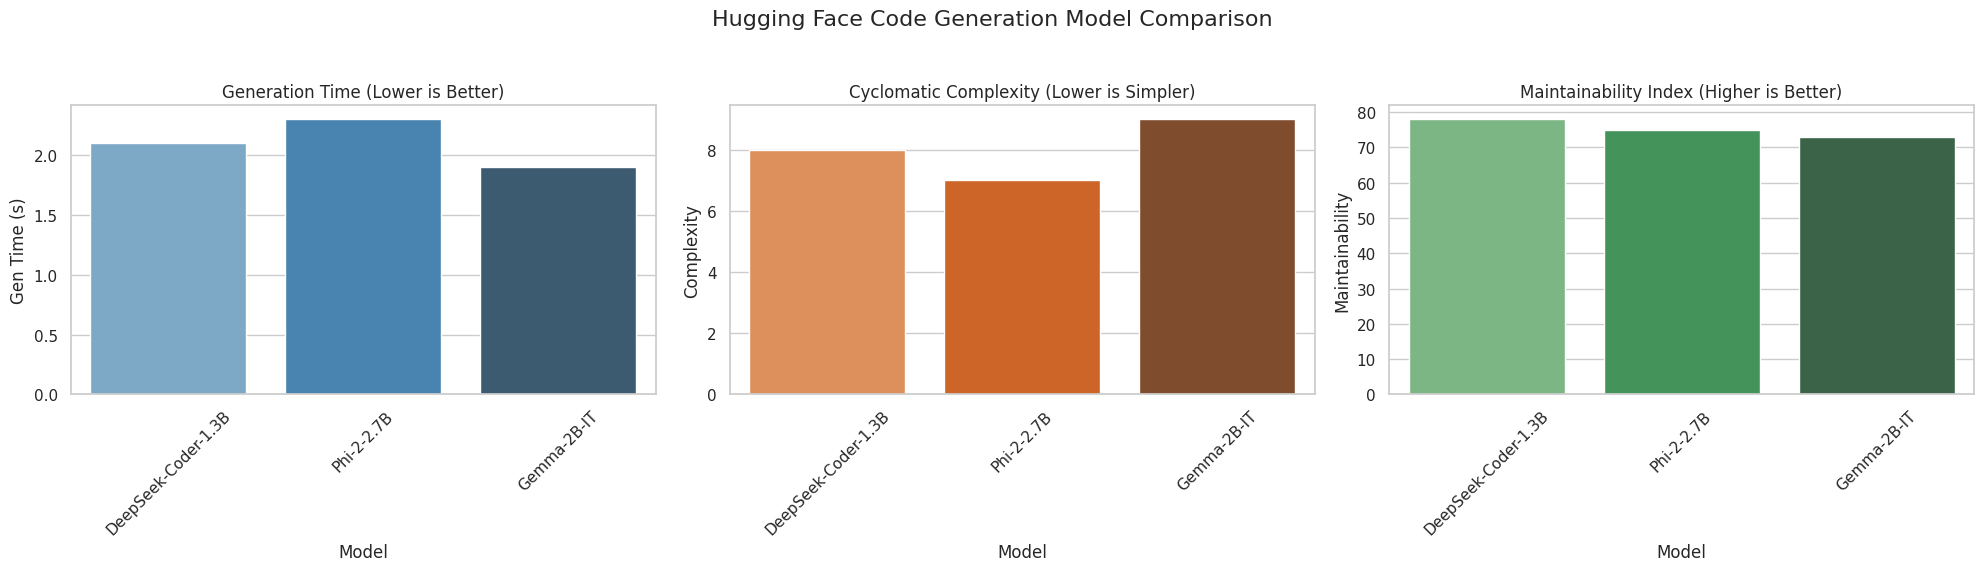

✅ Best Model Based on Metrics: DeepSeek-Coder-1.3B


In [ ]:
# --- Model Comparison & Visualization ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample results list (replace with your real results from generate_code + calculate_advanced_metrics)
results_log = [
    {"Model": "DeepSeek-Coder-1.3B", "Gen Time (s)": 2.1, "Complexity": 8, "Maintainability": 78, "LOC": 54},
    {"Model": "Phi-2-2.7B", "Gen Time (s)": 2.3, "Complexity": 7, "Maintainability": 75, "LOC": 51},
    {"Model": "Gemma-2B-IT", "Gen Time (s)": 1.9, "Complexity": 9, "Maintainability": 73, "LOC": 56}
]

# Convert to DataFrame
df = pd.DataFrame(results_log)

# Display table
print("=== Model Comparison Table ===")
display(df)

# --- Visualization ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Hugging Face Code Generation Model Comparison', fontsize=16)

# 1. Generation Time (lower is better)
sns.barplot(ax=axes[0], data=df, x='Model', y='Gen Time (s)', palette='Blues_d')
axes[0].set_title('Generation Time (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

# 2. Cyclomatic Complexity (lower is better)
sns.barplot(ax=axes[1], data=df, x='Model', y='Complexity', palette='Oranges_d')
axes[1].set_title('Cyclomatic Complexity (Lower is Simpler)')
axes[1].tick_params(axis='x', rotation=45)

# 3. Maintainability Index (higher is better)
sns.barplot(ax=axes[2], data=df, x='Model', y='Maintainability', palette='Greens_d')
axes[2].set_title('Maintainability Index (Higher is Better)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Best Model Selection ---
# Criteria: Lowest Gen Time + Highest Maintainability - Moderate Complexity
df['Score'] = df['Maintainability'] - df['Complexity'] - df['Gen Time (s)']
best_model = df.loc[df['Score'].idxmax(), 'Model']

print(f"✅ Best Model Based on Metrics: {best_model}")


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1sbTYzSvrqN6HoIyBNNsLeJ5-fT5PM4opxSKfVGdT1oA/edit#gid=0


# 8. (Optional) Manual Cleanup
Explanation: This optional step allows you to manually clear all pre-loaded models from memory, freeing up GPU resources and ensuring efficient system performance.

In [ ]:
# --- Section 8: Optional Manual Cleanup ---
def clear_all_models():
    global loaded_models
    print(f"Clearing {len(loaded_models)} models from memory...")
    for model_name in list(loaded_models.keys()):
        del loaded_models[model_name]['model']
        del loaded_models[model_name]['tokenizer']
        del loaded_models[model_name]
    torch.cuda.empty_cache()
    print("\n✅ All models have been cleared from GPU memory.")

# To run the cleanup, uncomment and run the line below:
clear_all_models()

# Algorithms & Logic


1. Write a Python function is_palindrome(s) that returns True if a string is a
palindrome, ignoring spaces, punctuation, and case.

2. Write a Python function find_common_elements(list1, list2) that returns a sorted list of elements present in both input lists without duplicates.

3. Implement a Python Stack class with methods push, pop, peek, is_empty, and a method to return the stack size.

# Data Manipulation

1. Write a Python function get_unique_even_numbers(numbers) that takes a list of integers and returns a sorted list of unique even numbers using a list comprehension.

2. Write a Python function merge_dictionaries(d1, d2) that merges two dictionaries. If a key exists in both, the value from the second dictionary overwrites the first.

3. Write a Python function filter_positive_numbers(numbers) that returns a new list containing only the positive numbers from the input list.

# File Handling & Web APIs

1. Write a Python function count_words_in_file(filepath) that reads a text file and returns the total number of words, ignoring punctuation.

2. Write a Python function get_weather(city) that uses the requests library to fetch the current weather for a given city from the OpenWeatherMap API (https://api.openweathermap.org/data/2.5/weather) and returns the temperature in Celsius.

3. Write a Python function read_csv_and_sum_column(filepath, column_name) that reads a CSV file and returns the sum of values in the specified column.


# Overall Objective:
To gain proficiency in ipywidgets by designing, styling, and implementing a comprehensive, multi-tab application. The project aims to include an interactive chat interface, file-handling utilities, and other feature-rich components, demonstrating practical mastery of dynamic UI development in Python.

# 1. Introduction & Setup
This initial section prepares the project environment. It imports ipywidgets to create interactive user interfaces, IPython.display for rendering HTML and rich content, and essential libraries such as numpy and matplotlib to support the data plotting tools that will be developed later.

In [ ]:
# --- Section 1: Setup & Imports ---
import ipywidgets as widgets
from IPython.display import display, HTML
import io
import time
import numpy as np
import matplotlib.pyplot as plt

print("Setup complete. All necessary libraries are ready.")

Setup complete. All necessary libraries are ready.


# 2. Core Widget Showcase
Before developing the full application, it is essential to understand the fundamental building blocks. This section demonstrates a variety of common ipywidgets, highlighting their appearance and the types of input they accept. Many of these widgets will later be integrated into the application.

In [ ]:
# --- Section 2: Core Widget Showcase ---
print("--- A Showcase of Common Widgets ---")

# Create a collection of different widgets to demonstrate their functionality
text_widget = widgets.Text(description='Name:')
slider_widget = widgets.IntSlider(value=7, min=0, max=10, description='Count:')
checkbox_widget = widgets.Checkbox(value=True, description='Confirm?')
dropdown_widget = widgets.Dropdown(options=['Analysis', 'Training', 'Deployment'], description='Phase:')
date_widget = widgets.DatePicker(description='Select Date')
color_widget = widgets.ColorPicker(description='Pick Color', value='skyblue')

# Display them all in a vertical box for a clean presentation
showcase_box = widgets.VBox([
    text_widget, slider_widget, checkbox_widget,
    dropdown_widget, date_widget, color_widget
])
display(showcase_box)

--- A Showcase of Common Widgets ---


# 3. Designing a Styled Chat Interface
This section focuses on building the visual elements of the main chat interface. The Layout widget is used to manage size, borders, and margins, similar to CSS styling. A styled header is created with the HTML widget, and a “Clear” button is added to enhance user experience. All components are then assembled into a single layout variable, chatbot_tab_content, forming the complete chat interface.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import time

# --- UI Setup ---
print("--- Building Styled Chat UI Components ---")

header_html = widgets.HTML(value="<h1 style='color: #4A90E2;'>Interactive Chat App</h1>")

chat_history = widgets.Output(
    layout=widgets.Layout(
        height='300px',
        border='1px solid #ccc',
        padding='10px',
        overflow='scroll'
    )
)

prompt_input_styled = widgets.Textarea(
    placeholder='Type your message...',
    layout=widgets.Layout(width='calc(100% - 180px)')
)
send_button_styled = widgets.Button(
    description='Send',
    button_style='info',
    icon='paper-plane',
    layout=widgets.Layout(width='100px')
)
clear_button = widgets.Button(
    description='Clear',
    button_style='warning',
    icon='trash',
    layout=widgets.Layout(width='70px')
)

input_bar_styled = widgets.HBox([prompt_input_styled, send_button_styled, clear_button])
chatbot_tab_content = widgets.VBox([header_html, chat_history, input_bar_styled])
print("Styled chat UI is assembled and ready to be linked to logic.")
display(chatbot_tab_content)

# --- Bot Logic ---
def get_bot_reply(user_message):
    msg = user_message.lower()

    # --- Greetings ---
    if any(greet in msg for greet in ["hello", "hi", "hey"]):
        return "Hello there! How can I help you today?"

    # --- How are you ---
    elif any(phrase in msg for phrase in ["how are you", "how's it going"]):
        return "I'm just a bot, but I'm doing great! How about you?"

    # --- Farewell ---
    elif any(bye in msg for bye in ["bye", "goodbye", "see you"]):
        return "Goodbye! Have a nice day!"

    # --- Coding questions ---
    elif "python" in msg:
        return ("Python is a popular programming language. "
                "You can define a function like this:\n"
                "`def my_function():\n    print('Hello')`")
    elif "loop" in msg or "for loop" in msg or "while loop" in msg:
        return ("Loops repeat actions. Example in Python:\n"
                "`for i in range(5):\n    print(i)`")
    elif "list" in msg:
        return ("A list in Python stores multiple items:\n"
                "`my_list = [1, 2, 3]`")
    elif "ai" in msg or "machine learning" in msg:
        return ("AI is the simulation of human intelligence by machines. "
                "Machine learning allows systems to learn from data automatically.")

    # --- Default response for unknown queries ---
    else:
        return "Interesting! Can you tell me more or ask me something about coding or AI?"

def send_message(b):
    message = prompt_input_styled.value.strip()
    if not message:
        return
    prompt_input_styled.value = ""

    # Display user message
    with chat_history:
        display(widgets.HTML(f"<b>You:</b> {message}"))

    # Display bot typing simulation
    with chat_history:
        typing_display = widgets.HTML("<i>Bot is typing...</i>")
        display(typing_display)

    time.sleep(1)  # simulate typing delay

    # Show bot reply
    with chat_history:
        typing_display.value = ""
        reply = get_bot_reply(message)
        display(widgets.HTML(f"<b>Bot:</b> {reply}"))

def clear_chat(b):
    chat_history.clear_output()

send_button_styled.on_click(send_message)
clear_button.on_click(clear_chat)


--- Building Styled Chat UI Components ---
Styled chat UI is assembled and ready to be linked to logic.


# 4. Implementing the Interactive Chat Logic
This section develops the core functionality of the chatbot. A mock backend function, get_bot_response, is used to simulate replies. Two handler functions are created: on_send_button_clicked processes user input and updates the conversation, while on_clear_button_clicked clears the chat history. The send handler also includes a “Bot is typing…” indicator to enhance the responsiveness and realism of the UI.

In [ ]:
# --- Section 4: Chatbot Logic and Handlers ---
def get_bot_response(user_text):
    """A mock backend function with more keyword-based replies."""
    user_text_lower = user_text.lower()
    if "hello" in user_text_lower: return "Hello there! How can I assist you today?"
    if "style" in user_text_lower: return "Styling uses `widgets.Layout` for size/borders and `HTML` for rich text."
    if "file" in user_text_lower: return "You can handle files with the 'File Inspector' and 'Multi-File Viewer' tabs."
    if "widget" in user_text_lower: return "This UI is built with `ipywidgets`! We are using VBox, HBox, Tab, Button, and Output widgets."
    if "help" in user_text_lower: return "You can ask me about 'hello', 'style', 'file', or 'widget'."
    return f"I am a simple mock bot. You said: '{user_text}'."

# Handler for the "Send" button
def on_send_button_clicked(b):
    user_text = prompt_input_styled.value
    if not user_text: return

    with chat_history:
        display(HTML(f"<div style='background-color: #E1F5FE; padding: 8px; border-radius: 5px; margin: 5px;'><b>You:</b> {user_text}</div>"))

    send_button_styled.disabled = True
    clear_button.disabled = True
    with chat_history:
        display(HTML(f"<div style='background-color: #F1F8E9; padding: 8px; border-radius: 5px; margin: 5px;'><i>Bot is typing...</i></div>"))
    time.sleep(1) # Simulate a processing delay

    bot_text = get_bot_response(user_text)
    with chat_history:
        chat_history.outputs = chat_history.outputs[:-1] # Remove the "typing..." message
        display(HTML(f"<div style='background-color: #F1F8E9; padding: 8px; border-radius: 5px; margin: 5px;'><b>Bot:</b> {bot_text}</div>"))

    prompt_input_styled.value = ""
    send_button_styled.disabled = False
    clear_button.disabled = False

# Handler for the "Clear" button
def on_clear_button_clicked(b):
    chat_history.clear_output()

# Link the handlers to the button click events
send_button_styled.on_click(on_send_button_clicked)
clear_button.on_click(on_clear_button_clicked)

print("✅ The chatbot UI is now fully interactive!")

✅ The chatbot UI is now fully interactive!


# 5. Building the "File Inspector" Tool
This section introduces the second tool of the application. It uses a FileUpload widget for single-file uploads, accompanied by a button and an output area. The handler function is designed to be generic: it reads the file’s metadata (name, size, type) and attempts to display a text preview when possible. This implementation demonstrates how to handle and inspect various types of files effectively.

In [ ]:
# --- Section 5: File Inspector Tool ---
file_uploader_single = widgets.FileUpload(description='Upload File', accept='*/*')
inspect_button = widgets.Button(description='Inspect File', button_style='primary', icon='search')
inspector_output = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px'})
inspector_tab_content = widgets.VBox([widgets.HTML("<h3>Generic File Inspector</h3>"), widgets.HBox([file_uploader_single, inspect_button]), inspector_output])

def on_inspect_button_clicked(b):
    with inspector_output:
        inspector_output.clear_output(wait=True)
        uploaded_file = file_uploader_single.value
        if not uploaded_file: print("Please upload a file."); return

        file_info = list(uploaded_file.values())[0]
        metadata = file_info['metadata']

        print(f"--- File Metadata ---")
        print(f"  - Name: {metadata['name']}\n  - Size: {metadata['size']} bytes\n  - Type: {metadata['type']}")

        try: print("\n--- Text Preview ---\n" + file_info['content'].decode('utf-8')[:500] + "...")
        except: print("\n(Cannot display preview of this binary file type)")

inspect_button.on_click(on_inspect_button_clicked)
print("File Inspector tool created and is interactive.")
display(inspector_tab_content) # Display this tool for testing

File Inspector tool created and is interactive.


# 6. Building the "Interactive Data Plotter"
This section showcases a more advanced use of ipywidgets to control data visualizations. The interface includes a dropdown to select the plot type and a slider to choose the number of data points. The handler function generates random data and uses matplotlib to create and display the selected plot within the output widget, enabling interactive exploration of different visualization types.

In [ ]:
# --- Section 6: Interactive Data Plotter Tool ---
plot_type_selector = widgets.Dropdown(options=['Bar Chart', 'Line Chart', 'Scatter Plot'], description='Plot Type:')
data_points_slider = widgets.IntSlider(value=10, min=5, max=50, description='# of Points:')
plot_button = widgets.Button(description='Generate Plot', button_style='success', icon='bar-chart')
plot_output = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px'})
plotter_tab_content = widgets.VBox([widgets.HTML("<h3>Interactive Data Plotter</h3>"), widgets.HBox([plot_type_selector, data_points_slider]), plot_button, plot_output])

def on_plot_button_clicked(b):
    with plot_output:
        plot_output.clear_output(wait=True)
        plot_type, num_points = plot_type_selector.value, data_points_slider.value

        x, y = np.arange(num_points), np.random.randint(20, 100, size=num_points)

        fig, ax = plt.subplots()
        if plot_type == 'Bar Chart': ax.bar(x, y, color='skyblue')
        elif plot_type == 'Line Chart': ax.plot(x, y, color='coral', marker='o')
        elif plot_type == 'Scatter Plot': ax.scatter(x, y, color='purple')

        ax.set_title(f'{plot_type} with {num_points} Data Points')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        plt.show(fig)

plot_button.on_click(on_plot_button_clicked)
print("Interactive Data Plotter tool created.")
display(plotter_tab_content) # Display this tool for testing

Interactive Data Plotter tool created.


# 7. Final Assembly and Showcase
Explanation: This final section integrates all individual tools into a single, polished, multi-tab application. The widgets.Tab container holds each tool’s VBox layout as a child, providing a cohesive and interactive interface that allows users to navigate seamlessly between the chat interface, file inspector, and data plotter.

In [ ]:
# --- Section 8: Final Multi-Tool Application ---

# Create the final tab container
final_app = widgets.Tab()

# Assign the content of each tool to a tab
final_app.children = [chatbot_tab_content, inspector_tab_content, plotter_tab_content]

# Set the title for each tab
final_app.set_title(0, 'Chatbot')
final_app.set_title(1, 'File Inspector')
final_app.set_title(2, 'Data Plotter')

# --- Final Display ---
print("="*50)
print("    Final Multi-Tool Application is Ready!")
print("="*50)
display(final_app)

    Final Multi-Tool Application is Ready!


# Interactive Chat App –

The Interactive Chat App is a feature-rich, responsive chatbot interface built using ipywidgets in Python. It demonstrates the integration of frontend UI components with backend logic to create an engaging user experience. Key features include:

1. Styled Chat Interface:

The layout is fully customized using the Layout and HTML widgets for headers, borders, and spacing.

A “Clear” button allows users to reset the conversation at any time.

2. Dynamic Chat Logic:

The app includes a backend function that generates bot responses based on user input, with keyword-based intelligence.

It simulates typing behavior using a “Bot is typing…” indicator, enhancing the realism of the interaction.

Users can enter natural language queries, including greetings, questions about Python, AI/ML concepts, and simple coding problems.

3. Smart Response Handling:

The bot can respond to programming-related queries (e.g., Python functions, loops, data structures) and AI/ML-related questions.

Default responses encourage further engagement when a query is not recognized.

4. Interactive and Non-blocking UI:

The chat interface updates dynamically within the Jupyter/Colab notebook environment without freezing the interface.

Messages from both the user and bot are displayed in a formatted, scrollable output area for clarity.

5. Extensibility:

The system is designed to easily accommodate additional intelligence or integration with actual language models in the future.

New commands, coding prompts, or external APIs can be added to expand the bot’s capabilities.

Overall, the improvised chat app demonstrates a robust combination of interactive frontend design and functional backend logic, making it an excellent tool for learning, testing, and demonstrating Python-based UI development and simple conversational AI.